#### Regression maps of monthly ERA5 SSTs with N34, ELI and ELIx
- Read/Calculate monthly ERA5 SST
- Read Nino34 1980-2023
- Regression: SST onto Niño-3.4, ELI and ELIx
    - 1980-2023
    - 1980-1989
    - 1990-2004
    - 2005-2019

      
Reference: Figs 5-8 of the following paper: <br>
https://www.jstage.jst.go.jp/article/jmsj/99/4/99_2021-051/_html/-char/en <br>
The correlation between the ENSO Modoki index and TC frequency over the WNP is <br>
- weak during 1975–1989, 
- strong and significant during 1990–2004, 
- weak again during 2005–2019.

#### Notes:
Use xr.apply_ufunc to write a simple 1D NumPy function, then automatically apply it along a named dimension across an entire xarray object. <br>
(conceptually without explicit Python loops) <br>
    
xr.apply_ufunc is <br>
- cleaner & safer
- dimension-aware: preserving xarray dims & coords
- dask-parallelizable

Use xr.apply_ufunc when:
- math is 1D (regression, correlation, filtering)
- data is ND with labeled dimensions
- avoid manual loops

Ming Ge Jan 2026

In [1]:
import os
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

In [2]:
from scipy.stats import linregress
def regress_and_p(y, x):
    mask = np.isfinite(y) & np.isfinite(x)
    if mask.sum() < 3:
        return np.nan, np.nan

    res = linregress(x[mask], y[mask])
    return res.slope, res.pvalue


In [3]:
def regress_sst(y, x):
    """
    y: SST time series at one grid point (1D, months)
    x: Nino3.4 index (1D, months)
    returns regression slope
    """
    mask = np.isfinite(y) & np.isfinite(x)
    if mask.sum() < 2:
        return np.nan
    slope = np.polyfit(x[mask], y[mask], 1)[0]  # slope
    return slope

def corrcoef_sst(y, x):
    mask = np.isfinite(y) & np.isfinite(x)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(x[mask], y[mask])[0,1]

In [4]:
def plot_regression(da, sig, var):
    '''

    '''
    fig = plt.figure(figsize=(10,4))
    #Pacific-centered ENSO map.
    ax = plt.axes(
        projection=ccrs.PlateCarree(central_longitude=180)
    )
    #print(da.month)
    # regression map
    im = ax.pcolormesh(
        da.longitude,
        da.latitude,
        da.mean(dim="month"),
        cmap="RdBu_r",
        vmin = 286, vmax=304,
        shading="auto",
        transform=ccrs.PlateCarree()
    )

    # Thin and overlay black crosses
    stride = 10

    sig_thin = sig.copy()
    sig_thin[:] = False
    sig_thin[::stride, ::stride] = sig[::stride, ::stride]

    lat2d, lon2d = np.meshgrid(da.latitude, da.longitude, indexing="ij")
    y_idx, x_idx = np.where(sig_thin)

    ax.scatter(
        lon2d[y_idx, x_idx],
        lat2d[y_idx, x_idx],
        s=8,
        c="k",
        marker="x",
        linewidths=0.3,
        transform=ccrs.PlateCarree()
    )

    # Add coastlines & formatting
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax.set_title(
        "SST Regression onto " + var + "\n"
        "Black crosses: p < 0.05 (F-test)"
    )

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.6,
        linestyle="--"
    )

    # show labels only on left & bottom
    gl.top_labels = False
    gl.right_labels = False

    # control tick locations
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30))

    # formatting
    gl.xlabel_style = {"size": 9}
    gl.ylabel_style = {"size": 9}

    #plt.colorbar(im, ax=ax, shrink=0.6)
    plt.colorbar(im, ax=ax,orientation="horizontal",
        shrink=0.4,label="SST(°K)" )
    plt.tight_layout()
    plt.show()

In [5]:

# Apply regression along “month” axis
# sst: (month, nx, ny)
# n34: (month,)

# Regression slope map by using xr.apply_ufunc:
# Apply a normal NumPy function along the month dimension 
# at every grid point, while keeping xarray’s labeled dimensions.

def regression_plot_3p(da, n34_da, eli_da, elix_da):
    # list of predictors and names
    predictors = [
        (n34_da,  "N34"),
        (eli_da,  "ELI"),
        (elix_da,  "ELIx"),
    ]

    for idx_da, name in predictors:
        print(name)
        # ensure correct dimension name
        if "month" not in idx_da.dims:
            idx_da = idx_da.rename({idx_da.dims[0]: "month"})

        # regression + p-value
        sst_reg, sst_p = xr.apply_ufunc(
            regress_and_p,
            da,          # SST (month, lat, lon) or (month, nx, ny)
            idx_da,      # index (month)
            input_core_dims=[["month"], ["month"]],
            output_core_dims=[[], []],
            vectorize=True,
            output_dtypes=[float, float],
        )

        # significance mask
        sig = sst_p < 0.05

        # plot
        plot_regression(da, sig, name)

In [6]:
def plot_sstDiff(data_diff, title):

    fig = plt.figure(figsize=(10,4))
    #Pacific-centered ENSO map.
    ax = plt.axes(
        projection=ccrs.PlateCarree(central_longitude=180)
    )

    im = ax.pcolormesh(
        da.longitude,
        da.latitude,
        data_diff,
        cmap="RdBu_r",
        vmin = -1, vmax=1,
        shading="auto",
        transform=ccrs.PlateCarree()
    )

    # Add coastlines & formatting
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax.set_title(title)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        alpha=0.6,
        linestyle="--"
    )

    # show labels only on left & bottom
    gl.top_labels = False
    gl.right_labels = False

    # control tick locations
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30))

    # formatting
    gl.xlabel_style = {"size": 9}
    gl.ylabel_style = {"size": 9}

    #plt.colorbar(im, ax=ax, shrink=0.6)
    plt.colorbar(im, ax=ax,orientation="horizontal",
        shrink=0.4,label="SST(°K)" )
    plt.tight_layout()
    plt.show()

#### Setup
Niño-3.4 region: 5°S–5°N, 170°W–120°W

In [7]:
year_s = 1980
year_e = 2023
n_year = year_e - year_s + 1

month_1d = ['01','02','03','04','05','06','07','08', '09', '10', '11', '12']

lat_s = -40
lat_e = 40
lon_s = 100
lon_e = 300

#### ERA5 SST

In [8]:
%%time
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/'
flnm_o = dir_o + 'sst_monthly_era5_1980-2003.nc'
dir_sst = '/glade/campaign/collections/rda/data/d633000/e5.oper.an.sfc/'

sst_list = []
time_list = []

if not os.path.exists(flnm_o):
    for year in range(year_s, year_e + 1):
        print(year)
        for month_s in month_1d:
            yyyymm = f"{year}{month_s}"
            ndays = calendar.monthrange(year, int(month_s))[1]

            flnm = (
                dir_sst + yyyymm +
                f"/e5.oper.an.sfc.128_034_sstk.ll025sc."
                f"{yyyymm}0100_{yyyymm}{ndays:02d}23.nc"
            )  
            
            if not os.path.exists(flnm):
                print(flnm , 'not exist')
                continue
            with xr.open_dataset(flnm) as ds:
                sstk_2d = (
                    ds.SSTK.mean(dim="time")
                .sel(latitude=slice(lat_e, lat_s),
                     longitude=slice(lon_s, lon_e))
                )

                sst_list.append(sstk_2d)
                time_list.append(pd.Timestamp(year, int(month_s), 1))
 
    data_3d = xr.concat(sst_list,
     dim=xr.DataArray(time_list, dims="month", name="month")
    )

    data_3d = data_3d.astype('float32')
    data_3d.to_netcdf(flnm_o)
    print(f"Saved to {flnm_o}")
else:
    with xr.open_dataset(flnm_o) as ds:
       da = ds["SSTK"]  

CPU times: user 1.03 s, sys: 260 ms, total: 1.29 s
Wall time: 2.25 s


#### Read Nino34 1980-2023

In [9]:
#Column 1: Month
#Column 2: A day index
#Column 3: The Nino34 index values
#Column 4 values (ELI),
#Column 7 values (ELIx)  

flnm_nino = dir_o + 'Book32p120_DbD_ELIx.txt'
month, N34, ELI, year, ELIx = np.loadtxt(flnm_nino,
    usecols=(0,2,3,5,6), unpack=True)

# Make DataFrame
df = pd.DataFrame({
    "year": year.astype(int),
    "month": month.astype(int),
    "N34": N34,
    "ELI": ELI,
    "ELIx": ELIx
})

# Group by year and month, then take mean
monthly_mean_per_year = df.groupby(["year", "month"])[["N34", "ELI", "ELIx"]].mean()

# because n34 data is from April 1980, I add three nan
n34 = np.concatenate([np.full(3, np.nan), monthly_mean_per_year.N34.values])

# shares the same month coordinates as your SSTK DataArray
n34_da = xr.DataArray(
    n34,
    dims="month",
    coords={"month": da["month"]},  # copy month coordinates
    name="N34"
)
# Convert n34 to DataArray  
#n34_da = xr.DataArray(n34, dims="month")

eli = np.concatenate([np.full(3, np.nan), monthly_mean_per_year.ELI.values])
#eli_da = xr.DataArray(eli, dims="month")
eli_da = xr.DataArray(
    eli,
    dims="month",
    coords={"month": da["month"]},  # copy month coordinates
    name="N34"
)

elix = np.concatenate([np.full(3, np.nan), monthly_mean_per_year.ELIx.values])
#elix_da = xr.DataArray(elix, dims="month")
elix_da = xr.DataArray(
    elix,
    dims="month",
    coords={"month": da["month"]},  # copy month coordinates
    name="N34"
)
#len(monthly_mean_per_year.N34.values), monthly_mean_per_year

#### Regression: SST onto Niño-3.4, ELI and ELIx (1980-2023)

N34


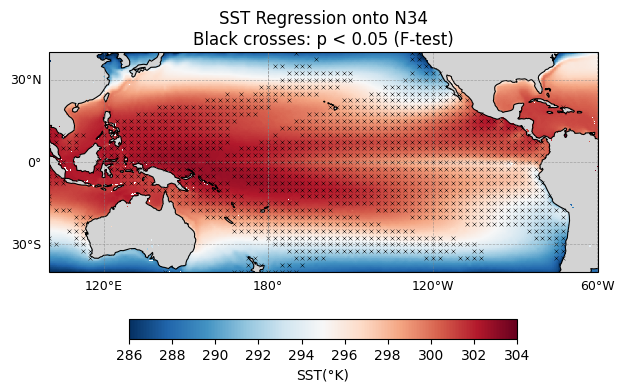

ELI


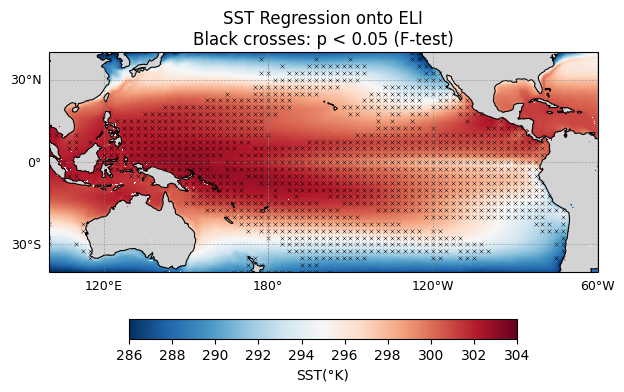

ELIx


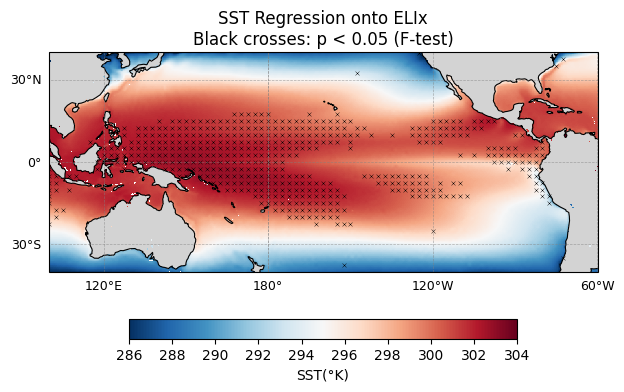

In [10]:
regression_plot_3p(da, n34_da, eli_da, elix_da)

#### Regression: SST onto Niño-3.4, ELI and ELIx (1980–1989)

N34


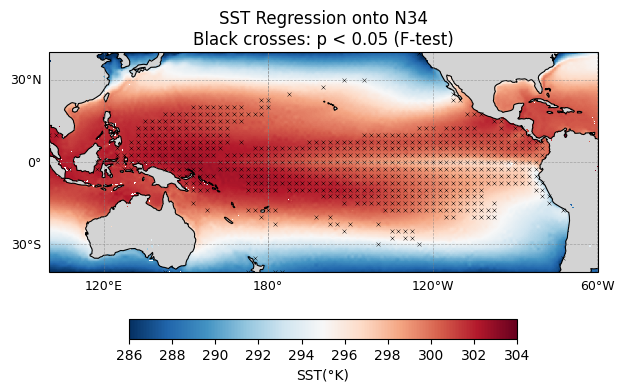

ELI


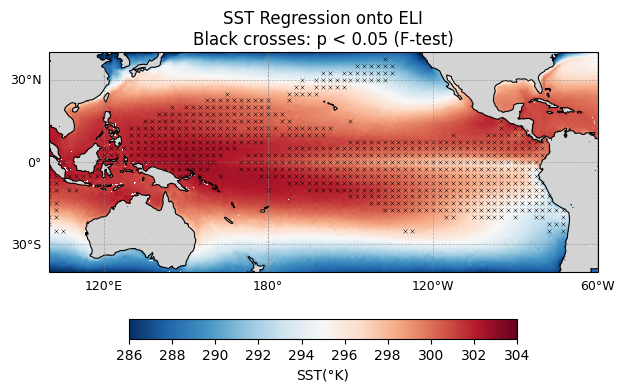

ELIx


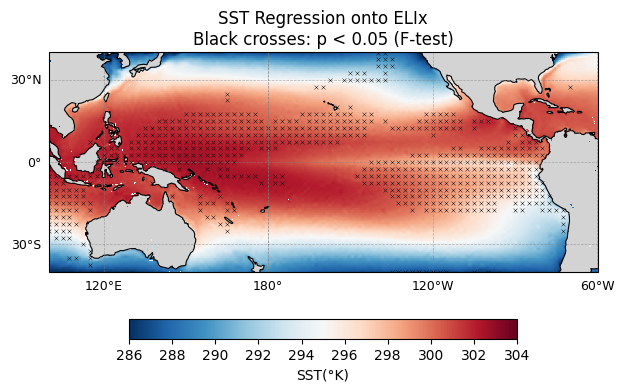

In [11]:
regression_plot_3p(da.sel(month=slice("1980-01-01", "1989-12-31")), 
                   n34_da.sel(month=slice("1980-01-01", "1989-12-31")), 
                   eli_da.sel(month=slice("1980-01-01", "1989-12-31")), 
                   elix_da.sel(month=slice("1980-01-01", "1989-12-31")))

#### Regression: SST onto Niño-3.4, ELI and ELIx (1990–2004)

N34


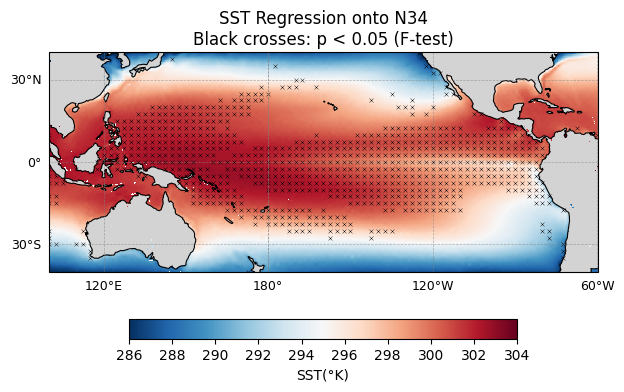

ELI


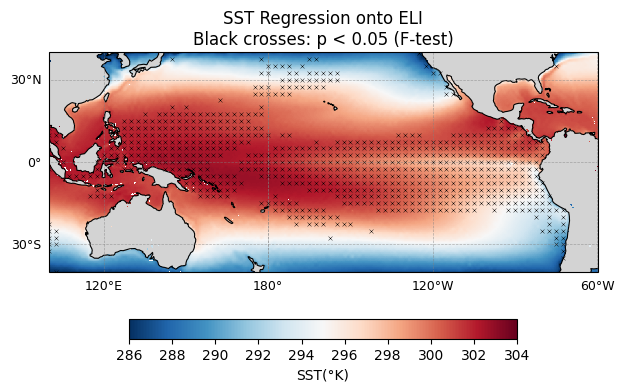

ELIx


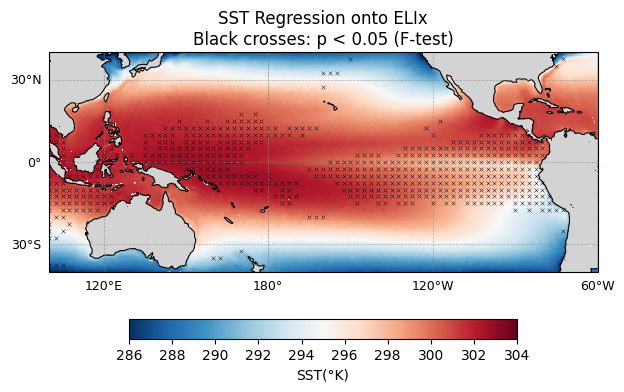

In [12]:
regression_plot_3p(da.sel(month=slice("1990-01-01", "2004-12-31")), 
                   n34_da.sel(month=slice("1990-01-01", "2004-12-31")), 
                   eli_da.sel(month=slice("1990-01-01", "2004-12-31")), 
                   elix_da.sel(month=slice("1990-01-01", "2004-12-31"))) 

#### Regression: SST onto Niño-3.4, ELI and ELIx (2005–2019)

N34


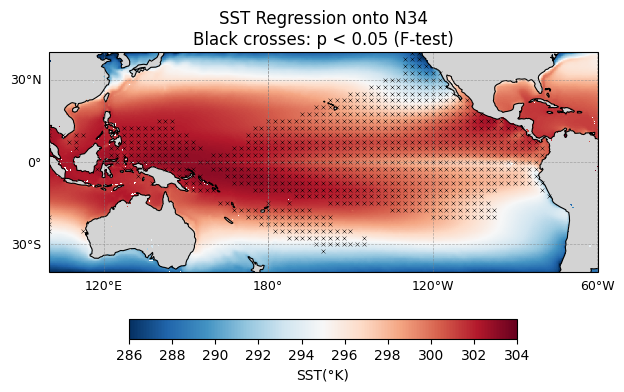

ELI


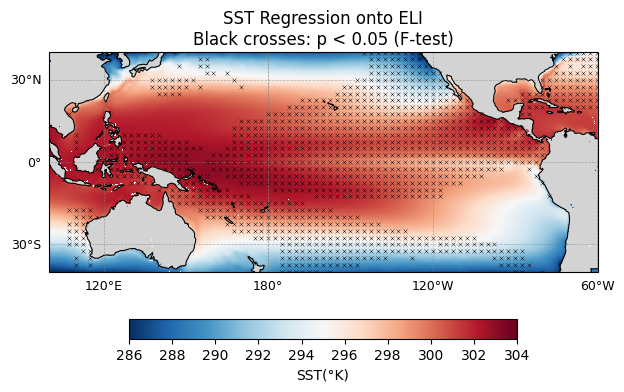

ELIx


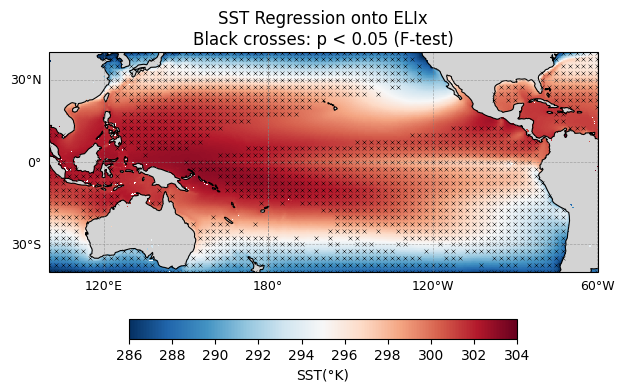

In [13]:
regression_plot_3p(da.sel(month=slice("2005-01-01", "2019-12-31")), 
                   n34_da.sel(month=slice("2005-01-01", "2019-12-31")), 
                   eli_da.sel(month=slice("2005-01-01", "2019-12-31")), 
                   elix_da.sel(month=slice("2005-01-01", "2019-12-31"))) 

#### SST check:

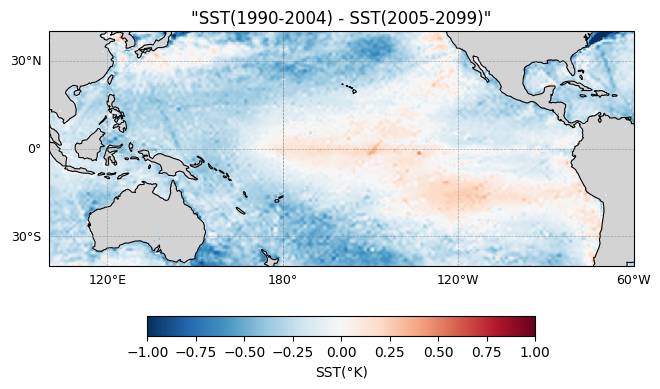

In [14]:
data_1980 = da.sel(month=slice("1980-01-01", "1989-12-31")).mean(dim="month")
data_1990 = da.sel(month=slice("1990-01-01", "2004-12-31")).mean(dim="month")
data_2005 = da.sel(month=slice("2005-01-01", "2019-12-31")).mean(dim="month")
plot_sstDiff(data_1990-data_2005, "SST(1990-2004) - SST(2005-2099)")

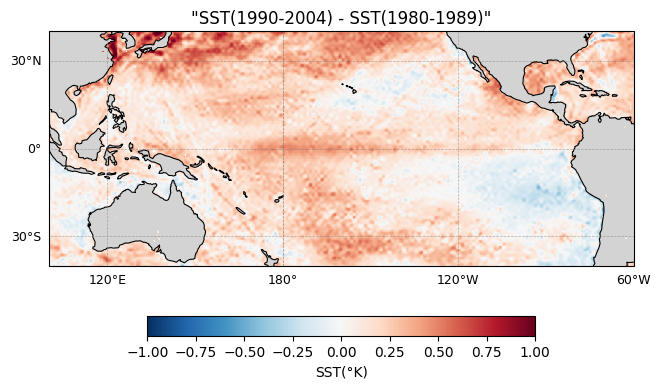

In [15]:
plot_sstDiff(data_1990-data_1980, "SST(1990-2004) - SST(1980-1989)")